In [19]:
# ==================================
# 1. 라이브러리 임포트 및 데이터 로드
# ==================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 관련
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 알고리즘
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
# 파일 경로는 환경에 맞게 수정
Input_data = pd.read_csv("Balanced_Expanded_IoT_Dataset.csv")








In [20]:
# ==================================
# 2. 데이터 확인 및 간단 EDA
# ==================================
print("데이터 크기:", Input_data.shape)
display(Input_data.head())
display(Input_data.info())
print("\n결측치 개수:\n", Input_data.isnull().sum())
print("\n타겟 분포:\n", Input_data['Target'].value_counts())

데이터 크기: (1149, 7)


,Unnamed: 0,Sl.No,Patient ID,Temperature Data,ECG Data,Pressure Data,Target
0,174,1175,1,43,-36,77,0
1,752,1420,2,37,75,76,1
2,467,1468,2,29,21,76,0
3,240,1241,2,38,0,77,0
4,667,1335,2,30,-25,77,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Unnamed: 0        1149 non-null   int64
 1   Sl.No             1149 non-null   int64
 2   Patient ID        1149 non-null   int64
 3   Temperature Data  1149 non-null   int64
 4   ECG Data          1149 non-null   int64
 5   Pressure Data     1149 non-null   int64
 6   Target            1149 non-null   int64
dtypes: int64(7)
memory usage: 63.0 KB


None


결측치 개수:
 Unnamed: 0          0
Sl.No               0
Patient ID          0
Temperature Data    0
ECG Data            0
Pressure Data       0
Target              0
dtype: int64

타겟 분포:
 Target
0    392
1    389
2    368
Name: count, dtype: int64


In [21]:
# ==================================
# 3. 독립변수(X), 종속변수(Y) 분리
# ==================================
X = Input_data.drop('Target', axis=1)
Y = Input_data['Target']

# ==================================
# 4. 데이터 전처리 (스케일링 및 학습/테스트 분할)
# ==================================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, shuffle=True
)

# ==================================
# 5. 여러 모델에 대한 파이프라인 구성
# ==================================
models = {
    "NaiveBayes": MultinomialNB(), 
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVM": SVC(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

pipelines = {}
for model_name, model in models.items():
    pipelines[model_name] = Pipeline([
        ("clf", model)
    ])


In [22]:


# ==================================
# 6. 모델 학습 및 평가 (기본)
# ==================================
results = {}
for model_name, pipeline in pipelines.items():
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    print(f"[{model_name}] 정확도: {acc:.4f}")

# ==================================
# 7. 모델 하이퍼파라미터 튜닝 예시 (GridSearchCV)
# ==================================
param_grid_rf = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    Pipeline([("clf", RandomForestClassifier(random_state=42))]),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(x_train, y_train)
print("\n[RandomForest GridSearchCV] 최적 파라미터:", grid_rf.best_params_)
print("[RandomForest GridSearchCV] 최고 정확도:", grid_rf.best_score_)

best_rf_model = grid_rf.best_estimator_
y_pred_rf_best = best_rf_model.predict(x_test)
acc_rf_best = accuracy_score(y_test, y_pred_rf_best)
print("[RandomForest GridSearchCV] 테스트 세트 정확도:", acc_rf_best)

# ==================================
# 8. 가장 성능 좋은 모델 선정
# ==================================
best_model_name = max(results, key=results.get)
best_model_acc = results[best_model_name]
print(f"\n현재까지의 기본 모델 중 최고 성능은 [{best_model_name}], 정확도: {best_model_acc:.4f}")

if acc_rf_best > best_model_acc:
    print(f"RandomForest 튜닝 모델이 더 좋습니다! 정확도: {acc_rf_best:.4f}")
    final_model = best_rf_model
else:
    print("기본 모델 중 하나가 더 좋거나 동일합니다. 그 모델 사용을 추천합니다.")
    final_model = pipelines[best_model_name]

[NaiveBayes] 정확도: 0.7000
[DecisionTree] 정확도: 0.9565
[LogisticRegression] 정확도: 0.9043
[SVM] 정확도: 0.9217
[RandomForest] 정확도: 0.9478
[KNN] 정확도: 0.9522
[GradientBoosting] 정확도: 0.9565

[RandomForest GridSearchCV] 최적 파라미터: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
[RandomForest GridSearchCV] 최고 정확도: 0.95975176172532
[RandomForest GridSearchCV] 테스트 세트 정확도: 0.9521739130434783

현재까지의 기본 모델 중 최고 성능은 [DecisionTree], 정확도: 0.9565
기본 모델 중 하나가 더 좋거나 동일합니다. 그 모델 사용을 추천합니다.



[최종 모델 혼동 행렬]


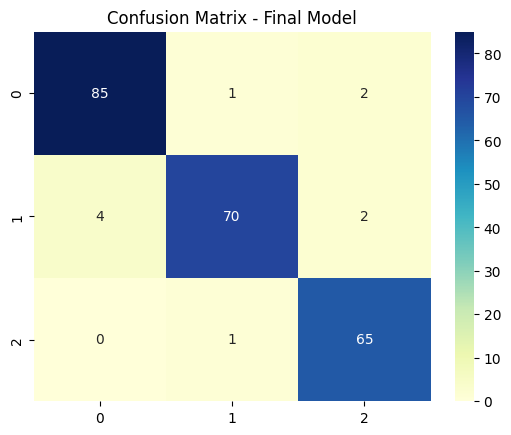


[최종 모델 분류 보고서]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        88
           1       0.97      0.92      0.95        76
           2       0.94      0.98      0.96        66

    accuracy                           0.96       230
   macro avg       0.96      0.96      0.96       230
weighted avg       0.96      0.96      0.96       230



In [23]:
# ==================================
# 9. 최종 모델 평가 (혼동 행렬 및 분류 보고서)
# ==================================
y_pred_final = final_model.predict(x_test)
print("\n[최종 모델 혼동 행렬]")
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Final Model")
plt.show()

print("\n[최종 모델 분류 보고서]")
print(classification_report(y_test, y_pred_final))


In [24]:
# ==================================
# 데이터 전처리 및 모델 재학습
# ==================================
# 'Sl.No' 및 'Unnamed: 0' 열 제거
X = Input_data.drop(['Sl.No', 'Unnamed: 0', 'Target'], axis=1)
Y = Input_data['Target']

# 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 학습/테스트 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, shuffle=True)

# 모델 학습
final_model = DecisionTreeClassifier(random_state=42)
final_model.fit(x_train, y_train)

# ==================================
# 10. 최종 모델 예측 예시
# ==================================
# 예측용 입력 데이터 (5개의 피처로 구성)
example_data = np.array([[1, 32, 0, 77]])  # Patient ID, Temperature Data, ECG Data, Pressure Data
example_data_scaled = scaler.transform(example_data)

# 예측
prediction = final_model.predict(example_data_scaled)
if prediction[0] == 0:
    print("\n예측 결과: The Patient Condition is Low")
elif prediction[0] == 1:
    print("\n예측 결과: The Patient Condition is Medium")
else:
    print("\n예측 결과: The Patient Condition is High")



예측 결과: The Patient Condition is Medium
